This Notebooks shows how to load a `seillra` model and use it to caluclate variant effect scores.

**STEP 1:** 

Import `seillra` and other packages:

In [ ]:
import os
import pandas as pd
import torch
import numpy as np

import seillra as sl

**STEP 2:**

- Decide on rank of approximate linear layers: 64
- Decide on the "mode" of the model -- `variant`
- If infierence is on arm64 hardware (e.g. macbook), use `qnnpack` as backend if `quant == "CPU"`
- We also use `projection = True` to get sequence classes. 

Then load the according model.

In [ ]:
# If using a MAC
if "qnnpack" in torch.backends.quantized.supported_engines:
    torch.backends.quantized.engine = "qnnpack"

In [9]:
rank = 256  # 1, 2, 4, 8, 16, 32, 64, 128, 256, 512, 1024, 2048
quant = "CPU"
model = sl.Sei_LLRA(k=rank, projection=True, mode="variant", quant=quant)

2026-01-23 12:07:30,614 - INFO - Checksum verified for url_a6038b62128b5b01_wts: 28a1a49ca62e4d67a62c170df3751f7255db6eea3923455c119c762dde446308
2026-01-23 12:07:30,614 - INFO - Loading state dict from /home/kostka/.cache/seillra/1.4/url_a6038b62128b5b01_wts
2026-01-23 12:07:31,117 - INFO - Model weights loaded and set to eval mode.
2026-01-23 12:07:31,677 - INFO - Checksum verified for url_9c83e76615711914_wts: ce0baa7e8533604ab579a37ada184832c716e61b285a04b2f97db9367b351df7
2026-01-23 12:07:31,677 - INFO - Loading state dict from /home/kostka/.cache/seillra/1.4/url_9c83e76615711914_wts
2026-01-23 12:07:31,832 - INFO - Model weights loaded and set to eval mode.
2026-01-23 12:07:31,882 - INFO - Checksum verified for url_f6f3b1c27e97399e_wts: ba3e530e53694c66a9573c0a38e0915986b95f19b99a962f357997eadaa33d44
2026-01-23 12:07:31,883 - INFO - Loading state dict from /home/kostka/.cache/seillra/1.4/url_f6f3b1c27e97399e_wts
2026-01-23 12:07:31,888 - INFO - Model weights loaded and set to eva

**STEP 3:**

Generate random variant data

In [11]:
# - random integer-encoded sequences
ref_sequences = torch.randint(0, 4, (16, 4096))
alt_sequences = ref_sequences.clone()

# - rotate base for the alternative allele at the center postition
center_idx = 4096 // 2
alt_sequences[:, center_idx] = (ref_sequences[:, center_idx] + 1) % 4

# - get one-hot encoding
x_ref = (
    torch.nn.functional.one_hot(ref_sequences, num_classes=4).permute(0, 2, 1).float()
)
x_alt = (
    torch.nn.functional.one_hot(alt_sequences, num_classes=4).permute(0, 2, 1).float()
)

print("Input tensor shapes:", x_ref.shape, x_alt.shape)

Input tensor shapes: torch.Size([16, 4, 4096]) torch.Size([16, 4, 4096])


**STEP 4:**

Calculate variant scores.
A common way is to use the maximum of absolute differences.

In [12]:
# - Generate sequenc class scores for ref and alt alleles
input = (x_ref, x_alt)
out_ref, out_alt = model(input)
print(out_ref.shape, out_alt.shape)

# - Get the maximum (across sequence classes) of the absolute difference between ref and alt
variant_effect = torch.max(torch.abs(out_ref - out_alt), dim=1).values
print("Variant effect shape:", variant_effect.shape)
print("Variant effect scores:", variant_effect)

torch.Size([16, 61]) torch.Size([16, 61])
Variant effect shape: torch.Size([16])
Variant effect scores: tensor([0.1966, 0.1966, 0.1964, 0.1966, 0.1966, 0.1966, 0.1967, 0.1967, 0.1967,
        0.1973, 0.1965, 0.0000, 1.7688, 0.1966, 0.5898, 0.1966])


**STEP 6:**

Take a look at the "results". 

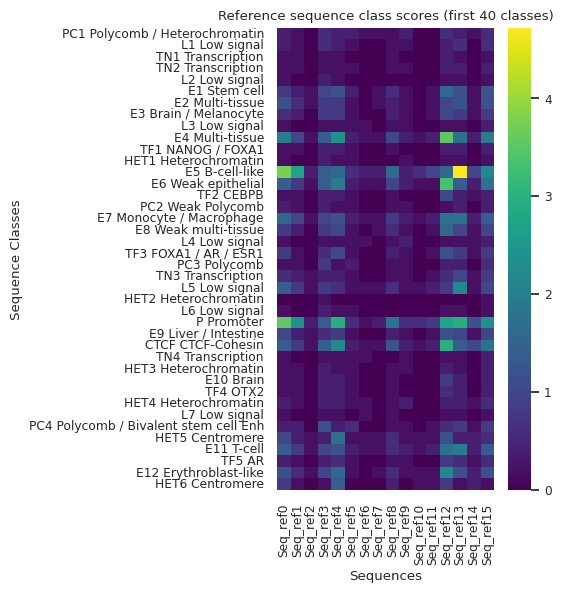

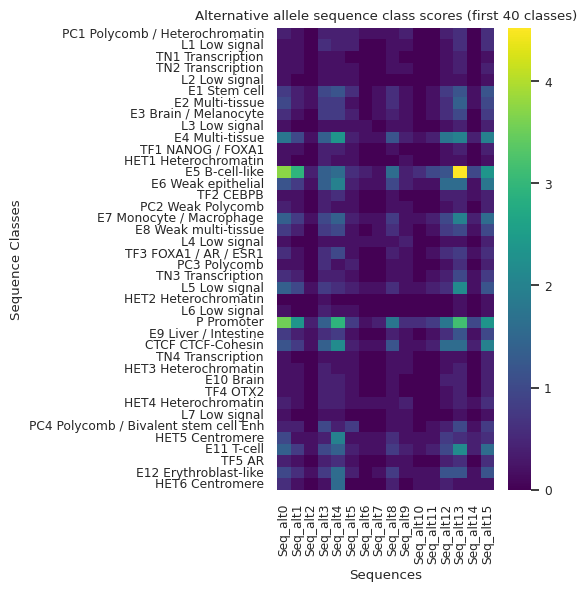

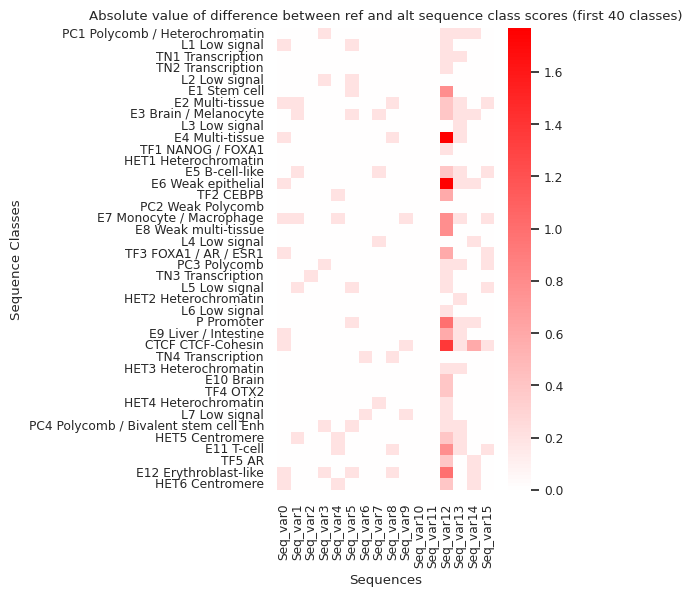

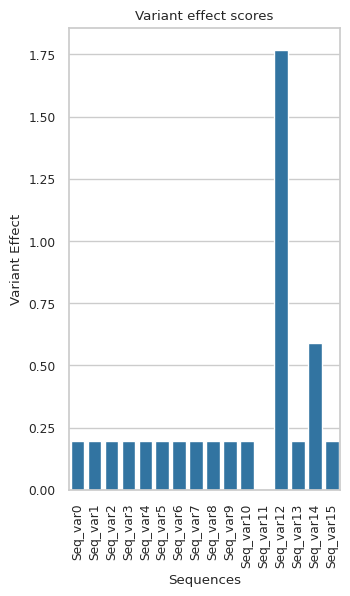

In [51]:
# - plot a heatmap of the reference sequence classes
import matplotlib.pyplot as plt
import seaborn as sns

# plt.rcParams.update(
#     {
#         "figure.figsize": (5, 3),
#         "font.size": 9,
#         "axes.titlesize": 10,
#         "axes.labelsize": 9,
#         "xtick.labelsize": 8,
#         "ytick.labelsize": 8,
#         "legend.fontsize": 8,
#     }
# )
sns.set_context("notebook", font_scale=0.8)
plt.figure(figsize=(3.5, 6))

sns.set_style("whitegrid")
sns.heatmap(
    out_ref.detach().numpy().T[:40, :],
    cmap="viridis",
    xticklabels=[f"Seq_ref{i}" for i in range(16)],
    yticklabels=model.proj.class_annot[:40],
)
plt.title("Reference sequence class scores (first 40 classes)")
plt.xlabel("Sequences")
plt.ylabel("Sequence Classes")
plt.show()

# - plot the alternative sequence classes
plt.figure(figsize=(3.5, 6))
sns.set_style("whitegrid")
sns.heatmap(
    out_alt.detach().numpy().T[:40, :],
    cmap="viridis",
    xticklabels=[f"Seq_alt{i}" for i in range(16)],
    yticklabels=model.proj.class_annot[:40],
)
plt.title("Alternative allele sequence class scores (first 40 classes)")
plt.xlabel("Sequences")
plt.ylabel("Sequence Classes")
plt.show()

# - plot the difference between ref and alt sequence classes
plt.figure(figsize=(3.5, 6))
sns.set_style("whitegrid")
sns.heatmap(
    (out_alt - out_ref).abs().detach().numpy().T[:40, :],
    cmap="bwr",
    center=0,
    xticklabels=[f"Seq_var{i}" for i in range(16)],
    yticklabels=model.proj.class_annot[:40],
)
plt.title(
    "Absolute value of difference between ref and alt sequence class scores (first 40 classes)"
)
plt.xlabel("Sequences")
plt.ylabel("Sequence Classes")
plt.show()

# - barplot of the variant effect scores
plt.figure(figsize=(3.5, 6))
sns.set_style("whitegrid")
sns.barplot(
    x=[f"Seq_var{i}" for i in range(16)],
    y=variant_effect.detach().numpy(),
)

plt.tick_params(axis="x", rotation=90)
plt.title("Variant effect scores")
plt.xlabel("Sequences")
plt.ylabel("Variant Effect")
plt.show()